In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
dataset = pd.read_csv('./WheatData.csv')
dataset.head()

,A,P,C,LK,WK,A_Coef,LKG,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [3]:
#Create x and y variables
x = dataset.drop('target',axis=1).to_numpy()
y = dataset['target'].to_numpy()

#Create Train and Test Datasets 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,stratify=y,random_state=100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_smt)
x_test2 = sc.transform(x_test)

#Model
from sklearn.svm import SVC

In [4]:
#Base SVM Model
from sklearn.metrics import classification_report, confusion_matrix  

for name,method in [('SVM', SVC())]: 
    method.fit(x_train2,y_train_smt)
    predict = method.predict(x_test2)
    print('\nEstimator: {}'.format(name)) 
    print(confusion_matrix(y_test,predict))  
    print(classification_report(y_test,predict))      


Estimator: SVM
[[12  1  1]
 [ 2 12  0]
 [ 0  0 14]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.92      0.86      0.89        14
           2       0.93      1.00      0.97        14

    accuracy                           0.90        42
   macro avg       0.90      0.90      0.90        42
weighted avg       0.90      0.90      0.90        42



In [5]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_svm = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC())])
pipeline.insert(0,pipe_svm)


# Set grid search params 

modelpara =[]

param_gridsvm = { 
           "clf__kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
           "clf__gamma" : [1e-1, 1e-2, 1e-3, 1e-4],
           "clf__C" : [1, 10, 100, 1000]}
modelpara.insert(0,param_gridsvm)     

In [6]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train_smt, 
                                                            y=y_train_smt,
                                                            cv=10,
                                                            train_sizes=np.linspace(.1,1,10),
                                                            scoring='accuracy',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.7, 1])
    plt.show()

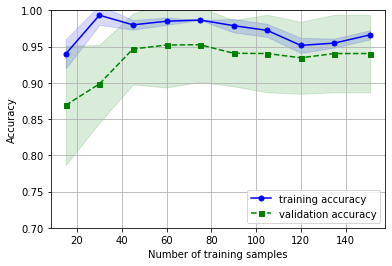

In [7]:
#Plot Learning Curve
plot_learning_curves(pipe_svm)

Model Evaluation - Accuracy Score
Support Vector Machines 0.90 +/- 0.07




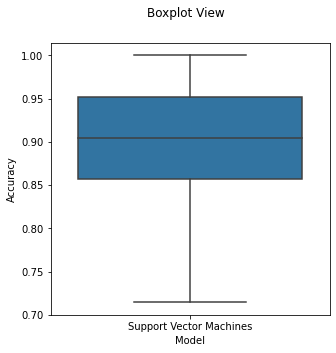

In [8]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Support Vector Machines',SVC(gamma='auto')))

#Model Evaluation
results =[]
names=[]
scoring ='accuracy'
print('Model Evaluation - Accuracy Score')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x,y,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

#Boxpot View
fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

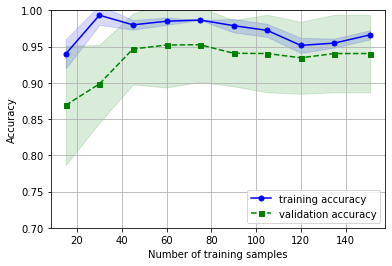

In [9]:
#Plot Learning Curve
plot_learning_curves(pipe_svm)

In [10]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2)
    gs_clf = gs_clf.fit(x_train_smt, y_train_smt)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    print('\nBest Parameters:',bestpara)
    
    #Confusion Matrix and Report
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred))     

In [1]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)

NameError: name 'pipeline' is not defined